In [1]:
from tqdm import tqdm
import pandas as pd
import gym
import blackjack as bj
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Часть первая, с блекджеком и стратегиями

In [2]:
import blackjack as bj
env = bj.BlackjackEnv(natural = True)

In [3]:
n = 500000
result = []
for i in range(n):
    env.reset()
    while bj.sum_hand(env.player)<19:
        env.step(1)
    res = env.step(0)
    result.append(res[1])        

Сколько в среднем проигрывам казино по нашей стратегии

In [4]:
np.mean(result)

-0.042186

#### TD-обучение: off-policy (Q-обучение)

In [5]:
env = bj.BlackjackEnv(natural = True)
nS, nA = env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n, env.action_space.n

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    return Q
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )
def get_s(s):
    return s[0]-1 + env.observation_space[0].n*(s[1]-1) + env.observation_space[0].n * env.observation_space[1].n * s[2]

In [6]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env._get_obs(), pi[get_s(env._get_obs())] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(100):
        observation, reward, done, info = env.step(a)
        s_prime, a_prime = env._get_obs(), pi[get_s(env._get_obs())] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[get_s(s)][a] = Q[get_s(s)][a] + alpha * (reward + gamma * np.max( Q[get_s(s_prime)] ) - Q[get_s(s)][a])
        s, a = s_prime, a_prime
        if done:
            return reward

In [7]:
env = bj.BlackjackEnv(natural = True)
total_episodes = 500000
gamma = 0.1

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
result = []
rew = []
for n in range(total_episodes):
    rew.append(Q_learning_episode(env, pi, Q, alpha=0.01, epsilon= 0.1, gamma=gamma))
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))
    if n % 1000 == 0:
        result.append(np.mean(rew))
        rew = []

env.close()

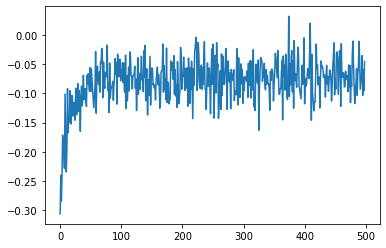

In [8]:
plt.plot(result[1:])

Text(0, 0.5, 'Текущая оценка')

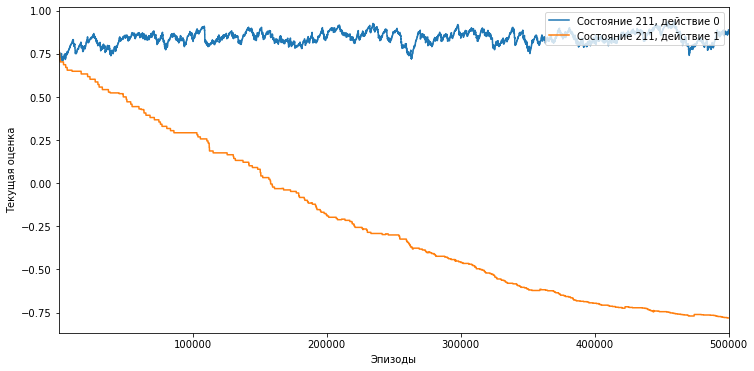

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ss = 19 + 32*6 # то есть у игрока на руках сумма карт равна 20, а у диллера открыта карта 7
for i,s_a in enumerate([(ss,0), (ss,1)]):
    s,a = s_a
    ax.plot(np.arange(1, total_episodes+1), [q[s][a] for q in Q_hist_Qlearn], label="Состояние %d, действие %d" % (s, a), color="C%d" % i)

ax.legend(loc="upper right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Текущая оценка")

Подберём оптимальные параметры

In [12]:
env = bj.BlackjackEnv(natural = True)
total_episodes = 500000
result = {}
for gamma in (0.05, 0.1, 0.3):
    for alpha in (0.01, 0.01, 0.1):
        for epsilon in (0.05, 0.1, 0.2):                       

            Q = get_random_Q(env)
            pi = compute_policy_by_Q(env, Q)
            for n in range(total_episodes):
                Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= epsilon, gamma=gamma)
                pi = compute_policy_by_Q(env, Q)

            n = 50000
            final_reward = []
            for i in range(n):
                env.reset()
                s = env._get_obs()
                while True:
                    s, reward, done, info = env.step(pi[get_s(s)])
                    if done:
                        final_reward.append(reward)
                        break
            print(f'for parameters gamma = {gamma}, alpha={alpha}, epsilon={epsilon} result={np.mean(final_reward)}')
            result.update({(gamma, alpha, epsilon): np.mean(final_reward)})
env.close()

for parameters gamma = 0.05, alpha=0.01, epsilon=0.05 result=-0.03525
for parameters gamma = 0.05, alpha=0.01, epsilon=0.1 result=-0.03444
for parameters gamma = 0.05, alpha=0.01, epsilon=0.2 result=-0.03155
for parameters gamma = 0.05, alpha=0.01, epsilon=0.05 result=-0.03295
for parameters gamma = 0.05, alpha=0.01, epsilon=0.1 result=-0.0344
for parameters gamma = 0.05, alpha=0.01, epsilon=0.2 result=-0.02361
for parameters gamma = 0.05, alpha=0.1, epsilon=0.05 result=-0.05347
for parameters gamma = 0.05, alpha=0.1, epsilon=0.1 result=-0.05345
for parameters gamma = 0.05, alpha=0.1, epsilon=0.2 result=-0.04136
for parameters gamma = 0.1, alpha=0.01, epsilon=0.05 result=-0.03282
for parameters gamma = 0.1, alpha=0.01, epsilon=0.1 result=-0.02634
for parameters gamma = 0.1, alpha=0.01, epsilon=0.2 result=-0.03642
for parameters gamma = 0.1, alpha=0.01, epsilon=0.05 result=-0.02478
for parameters gamma = 0.1, alpha=0.01, epsilon=0.1 result=-0.0313
for parameters gamma = 0.1, alpha=0.01,

In [13]:
env = bj.BlackjackEnv(natural = True)
env.reset()
gamma = 0.1
alpha = 0.01
epsilon = 0.2
total_episodes = 1000000
Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
reward_avg = []
reward = []
for n in range(total_episodes):
    reward.append(Q_learning_episode(env, pi, Q, alpha=alpha, epsilon= epsilon, gamma=gamma))
    pi = compute_policy_by_Q(env, Q)
    if n % 100000 == 0:
        reward_avg.append(np.mean(reward))
        reward = []

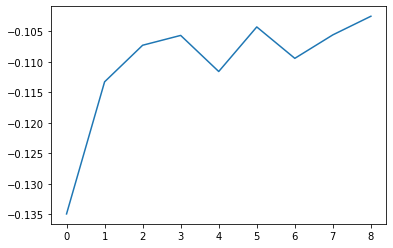

In [16]:
plt.plot(reward_avg[1:])

In [17]:
n = 500000
result = []
for i in tqdm(range(n)):
    env.reset()
    s = env._get_obs()
    while True:
        s, reward, done, info = env.step(pi[get_s(s)])
        if done:
            result.append(reward)
            break

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:28<00:00, 17670.23it/s]


Сколько в среднем проигрывам казино по нашей стратегии

In [18]:
np.mean(result)

-0.027531

# Часть вторая, удвоенная

Реализовала новый вариант блэкджека, где разрешено удвоение ставки

In [19]:
import blackjack_double as bj_d

In [20]:
env = bj_d.BlackjackEnv(natural = True)
nS, nA = env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n, env.action_space.n


def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    return Q
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )
def get_s(s):
    return s[0]-1 + env.observation_space[0].n*(s[1]-1) + env.observation_space[0].n * env.observation_space[1].n * s[2]

In [21]:
total_episodes = 1000000
gamma = 0.1
alpha = 0.01
epsilon = 0.2
env.reset()
                      
Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
reward_avg = []
reward = []
for n in tqdm(range(total_episodes)):
    reward.append(Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma))
    pi = compute_policy_by_Q(env, Q)
    Q_hist_Qlearn.append(np.copy(Q))
    if n % 100000 == 0:
        reward_avg.append(np.mean(reward))
        reward = []



100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:27<00:00, 6772.22it/s]


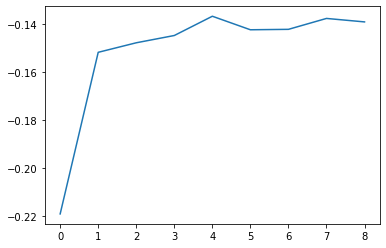

In [22]:
plt.plot(reward_avg[1:])

In [23]:
n = 500000
result = []
for i in tqdm(range(n)):
    env.reset()
    s = env._get_obs()
    while True:
        s, reward, done, info = env.step(pi[get_s(s)])
        if done:
            result.append(reward)
            break

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:30<00:00, 16305.49it/s]


Сколько в среднем проигрывам казино по нашей стратегии

In [24]:
np.mean(result)

-0.018636

# Часть третья, в главной роли — Дастин Хоффман

Реализовала вариант бледжека, где есть подсчёт карт по Hi-Opt 2

In [25]:
import blackjack_hi_opt_2 as bj_ho2

In [26]:
env = bj_ho2.BlackjackEnv(natural = True)
nS, nA = env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n * env.observation_space[3].n , env.action_space.n

def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    return Q
def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax( Q, axis=1 )
def get_s(s):
    return s[0]-1 + env.observation_space[0].n*(s[1]-1) + env.observation_space[0].n * env.observation_space[1].n * s[2] + \
        env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n *(s[3] + 32)

In [27]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.1, gamma=0.9):
    env.reset()
    s, a = env._get_obs(), pi[get_s(env._get_obs())] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(100):
        observation, reward, done, count, info = env.step(a)
        s_prime, a_prime = env._get_obs(), pi[get_s(env._get_obs())] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[get_s(s)][a] = Q[get_s(s)][a] + alpha * (reward + gamma * np.max( Q[get_s(s_prime)] ) - Q[get_s(s)][a])
        s, a = s_prime, a_prime
        if done:
            return reward

In [29]:
total_episodes = 10000000
gamma = 0.1
alpha = 0.01
epsilon = 0.2

Q_hist_Qlearn = [ ]

Q = get_random_Q(env)
pi = compute_policy_by_Q(env, Q)
reward_avg = []
reward = []
for n in tqdm(range(total_episodes)):
    reward.append(Q_learning_episode(env, pi, Q, alpha=0.01, epsilon= 0.1, gamma=gamma))
    pi = compute_policy_by_Q(env, Q)
    if n % 100000 == 0:
        reward_avg.append(np.mean(reward))
        reward = []


100%|██████████████████████████████████████████████████████████████████| 10000000/10000000 [2:33:24<00:00, 1086.39it/s]


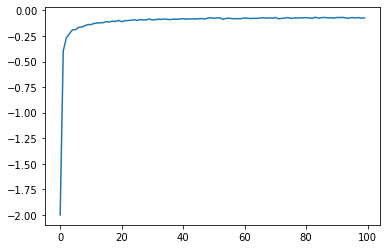

In [30]:
plt.plot(reward_avg)

In [31]:
n = 1000000
result = []
for i in tqdm(range(n)):
    env.reset()
    s = env._get_obs()
    while True:
        s, reward, done, count, info = env.step(pi[get_s(s)])
        if done:
            result.append(reward)
            break

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:51<00:00, 19420.93it/s]


Сколько в среднем проигрывам казино по нашей стратегии

In [32]:
np.mean(result)

-0.008626

Приблизились к тому, чтобы всреднем выигрывать у казино, но всё же так и не смогли переёти через 0